In [334]:
# Only these three packages are allowed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [335]:
class FLD:
    def __init__(self):
        self.mean_vectors = None
        self.sw = None
        self.sb = None
        self.w = None
        self.slope = None

    def fit(self, x, y):
        self.categories, _ = np.unique(y, return_counts = True)
        self.category_counts = len(self.categories)
        self.feature_counts = x.shape[1]
        self.mean_vectors = np.zeros((self.category_counts,self.feature_counts))
        self.sb = np.zeros((self.feature_counts,self.feature_counts))
        self.sw = np.zeros((self.feature_counts,self.feature_counts))
        total_mean = x.mean(axis=0)
        for cat in self.categories:
            x_c = x[y == cat]
            self.mean_vectors[cat] = x_c.mean(axis=0)
            centered_class_mean = (self.mean_vectors[cat]-total_mean).reshape(-1,1)
            self.sb += x_c.shape[0]*centered_class_mean @ centered_class_mean.T
            self.sw += (x_c - self.mean_vectors[cat]).T@(x_c - self.mean_vectors[cat])

        eigen_value, eigen_vector = np.linalg.eig(np.linalg.inv(self.sw)@self.sb)
        max_eigen_value = np.argmax(eigen_value)
        self.weights = eigen_vector[:,max_eigen_value].reshape(self.feature_counts,1)

    def predict_using_class_mean(self,x_test):
        size = x_test.shape[0]
        y_pred = np.zeros((size,),dtype=np.int64)
        index = 0

        for data in x_test:
            max = float('inf')
            for cat in self.categories:
                distance = np.square(np.sum(np.power(data - self.mean_vectors[cat],2)))
                if distance < max:
                    max = distance
                    prediction = cat

            y_pred[index] = prediction
            index += 1
            
        return y_pred

    def predict_using_knn(self, x, y, x_test, k=1):
        x_train_proj = np.zeros((x.shape[0],))
        y_pred = np.zeros((x_test.shape[0],),dtype=np.int64)
        x_train_proj_index = 0
        for data in x:
            data = data.reshape(self.feature_counts,1)
            result = self.weights.T@data
            x_train_proj[x_train_proj_index] = result[0][0]
            x_train_proj_index += 1
        
        y_pred_index = 0
        
        for data in x_test:
            data = data.reshape(self.feature_counts,1)
            result = self.weights.T@data
            data_proj = result[0][0]
            distance = np.abs(x_train_proj - data_proj)
            nearest_index = np.argpartition(distance, k)
            y_filtered = y[nearest_index[:k]]
            category, counts = np.unique(y_filtered, return_counts=True)
            most_index = np.argmax(counts)
            y_pred[y_pred_index] = category[most_index]
            y_pred_index += 1

        return y_pred

    def show_confusion_matrix(self, y, y_pred):
        confusion_matrix = np.zeros((self.category_counts,self.category_counts),dtype=np.int64)
        for index, data in np.ndenumerate(y):
            confusion_matrix[data][y_pred[index[0]]] += 1
        fig, ax = plt.subplots(figsize=(7.5, 7.5))
        confusion_plot = ax.matshow(confusion_matrix, cmap=plt.cm.Blues, alpha=0.3)
        for i in range(confusion_matrix.shape[0]):
            for j in range(confusion_matrix.shape[1]):
                ax.text(x=j, y=i,s=confusion_matrix[i][j], va='center', ha='center', size='xx-large')
        fig.colorbar(confusion_plot)
        plt.xlabel('Predicted label', fontsize=18)
        plt.ylabel('True label', fontsize=18)
        plt.title('Confusion Matrix', fontsize=18)
        plt.show()

    def plot_projection(self, x, y):
        fig = plt.figure()
        plt.scatter([row[0] for row in x[y==0]],[row[1] for row in x[y==0]],c='green',label=0)
        plt.scatter([row[0] for row in x[y==1]],[row[1] for row in x[y==1]],c='red',label=1)
        plt.scatter([row[0] for row in x[y==2]],[row[1] for row in x[y==2]],c='yellow',label=2)
        plt.legend()
        plt.axline((-self.weights[0][0],-self.weights[1][0]),(self.weights[0][0],self.weights[1][0]))
        self.slope = (self.weights[1][0]-(-self.weights[1][0])) / (self.weights[0][0]-(-self.weights[0][0]))
        print(self.slope)
        print(self.weights[0][0])
        print(self.weights[1][0])
        intercept = self.weights[1][0] - (self.slope*self.weights[0][0])

        for data in x[y==0]:
            data = data.reshape(self.feature_counts,1)
            proj = (self.weights.T@data)*self.weights
            plt.plot([data[0][0],proj[0][0]],[data[1][0],proj[1][0]],"g.:",alpha=0.2)

        for data in x[y==1]:
            data = data.reshape(self.feature_counts,1)
            proj = (self.weights.T@data)*self.weights
            plt.plot([data[0][0],proj[0][0]],[data[1][0],proj[1][0]],"r.:",alpha=0.2)

        for data in x[y==2]:
            data = data.reshape(self.feature_counts,1)
            proj = (self.weights.T@data)*self.weights
            plt.plot([data[0][0],proj[0][0]],[data[1][0],proj[1][0]],"y.:",alpha=0.2)

        plt.title('Projection Line: w={}, b={}'.format(self.slope, intercept), fontsize=18)
    
        plt.show()


    def accuracy_score(self, y, y_pred):
        size = y.shape[0]
        confusion_matrix = np.zeros((self.category_counts,self.category_counts),dtype=np.int64)
        for index, data in np.ndenumerate(y):
            confusion_matrix[data][y_pred[index[0]]] += 1
        return np.sum(np.diag(confusion_matrix)) / size

In [336]:
class MultiClassLogisticRegression:
	
	def __init__(self):
		self.epoch = []
		self.train_loss = []
		self.weights = None

	def fit(self, x, y, batch_size=16, lr=0.001, epochs=100):
		sample_size = x.shape[0]
		feature_size = x.shape[1]
		self.cat_num = len(np.unique(y))
		self.weights = np.zeros((feature_size, self.cat_num),dtype=np.float64)
		interval = len(x)//batch_size
		for epoch in range(epochs):
			loss = 0
			for batch_num in range(len(x)//batch_size):
				if batch_num != interval - 1:
					x_subset = x[(batch_num*batch_size):(batch_num*batch_size)+batch_size,:]
					y_subset = y[(batch_num*batch_size):(batch_num*batch_size)+batch_size]
				else:
					x_subset = x[batch_num*batch_size:,:]
					y_subset = y[batch_num*batch_size:]
				y_one_hot = np.eye(self.cat_num)[y_subset]
				prediction = self.softmax(x_subset@self.weights) # 1000x2, 2x3 -> 1000x3
				gradient = 1/sample_size*(x_subset.T@(prediction - y_one_hot)) # 4x1000, 1000x3 -> 4x3
				self.weights -= lr * gradient
				loss += self.cross_entropy(y_one_hot,prediction)
			
			self.epoch.append(epoch)
			self.train_loss.append(loss)

	def predict(self, x):
		y_pred = self.softmax(x@self.weights)
		y_pred = np.argmax(y_pred, axis=1)
		
		return y_pred

	def evaluate(self, x, y):
		size = y.shape[0]
		y_pred = self.softmax(x@self.weights)
		y_pred = np.argmax(y_pred, axis=1)
		confusion_matrix = np.zeros((self.cat_num,self.cat_num),dtype=np.int64)
		for index, data in np.ndenumerate(y):
				confusion_matrix[data][y_pred[index[0]]] += 1
		return np.sum(np.diag(confusion_matrix)) / size

	def softmax(self, z): # all features 乘上三組 weight 後會是一個 1*3 的向量，再用 softmax 轉換成機率
		return np.exp(z)/np.sum(np.exp(z),axis=1).reshape(-1,1)

	def cross_entropy(self, y, probs):
		loss = 0
		for data_num in range(y.shape[0]):
			for cat_num in range(self.cat_num):
				loss += y[data_num][cat_num] * np.log(probs[data_num][cat_num])
		
		return -loss

	def show_confusion_matrix(self, x, y):
		y_pred = self.softmax(x@self.weights)
		y_pred = np.argmax(y_pred, axis=1)
		confusion_matrix = np.zeros((self.cat_num,self.cat_num),dtype=np.int64)
		for index, data in np.ndenumerate(y):
				confusion_matrix[data][y_pred[index[0]]] += 1
		fig, ax = plt.subplots(figsize=(7.5, 7.5))
		confusion_plot = ax.matshow(confusion_matrix, cmap=plt.cm.Blues, alpha=0.3)
		for i in range(confusion_matrix.shape[0]):
				for j in range(confusion_matrix.shape[1]):
						ax.text(x=j, y=i,s=confusion_matrix[i][j], va='center', ha='center', size='xx-large')
		fig.colorbar(confusion_plot)
		plt.xlabel('Predicted label', fontsize=18)
		plt.ylabel('True label', fontsize=18)
		plt.title('Confusion Matrix', fontsize=18)
		plt.show()

	def plot_curve(self):
		plt.plot(self.epoch,self.train_loss,c="blue",label="Train CE loss")
		plt.title("Training loss")
		plt.xlim(-10)
		plt.xlabel("Epoch")
		plt.ylabel("CE loss")
		plt.legend()

# Prepare data for Q1 ~ Q12

In [337]:
df_train = pd.DataFrame(pd.read_csv("./dataset/PR_HW2_blob_train.csv"))
df_test  = pd.DataFrame(pd.read_csv("./dataset/PR_HW2_blob_test.csv"))

In [338]:
x_train = df_train[['Feature1', 'Feature2']].to_numpy()
y_train = df_train[['Target']].to_numpy(dtype=np.int64).ravel()

x_test = df_test[['Feature1', 'Feature2']].to_numpy()
y_test = df_test[['Target']].to_numpy(dtype=np.int64).ravel()

print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test",  x_test.shape)
print("y_test",  y_test.shape)

x_train (1000, 2)
y_train (1000,)
x_test (1000, 2)
y_test (1000,)


# MultiClass Logistic Regression

In [339]:
# For Q1
lr = 0.001
batch_size = 1000
epoch = 3000

logistic_reg = MultiClassLogisticRegression()
logistic_reg.fit(x_train, y_train, lr=lr, batch_size=batch_size, epochs=epoch)

In [340]:
# For Q2
print('Training acc: ', logistic_reg.evaluate(x_train, y_train))

Training acc:  0.894


In [341]:
# For Q3
print('Testing acc: ', logistic_reg.evaluate(x_test, y_test))

Testing acc:  0.884


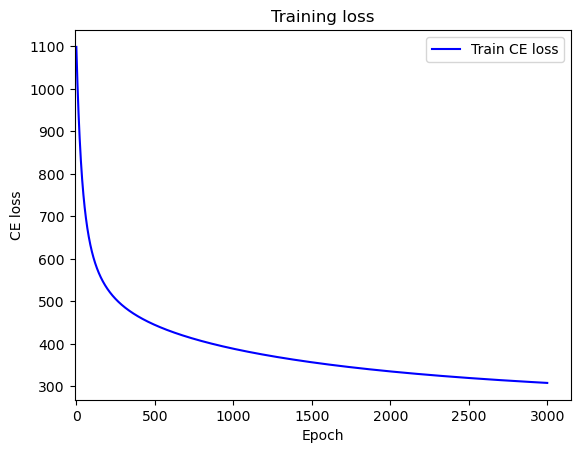

In [342]:
# For Q4
logistic_reg.plot_curve()

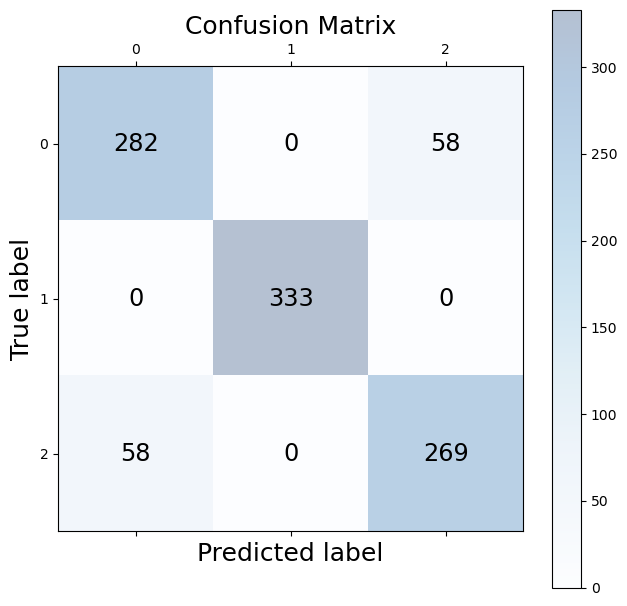

In [343]:
# For Q5
logistic_reg.show_confusion_matrix(x_test, y_test)

# Fisher's Linear Discriminant Analysis

In [344]:
fld = FLD()

fld.fit(x_train, y_train)

In [345]:
# For Q6
print("Class mean vector: ", fld.mean_vectors)

Class mean vector:  [[-4.17505764  6.35526804]
 [-9.43385176 -4.87830741]
 [-2.54454008  7.53144179]]


In [346]:
# For Q7
print("Within-class scatter matrix SW: ", fld.sw)

Within-class scatter matrix SW:  [[1052.70745046  -12.5828441 ]
 [ -12.5828441   971.29686189]]


In [347]:
# For Q8
print("Between-class scatter matrix SB: ", fld.sb)

Between-class scatter matrix SB:  [[ 8689.12907035 16344.86572983]
 [16344.86572983 31372.93949414]]


In [348]:
# For Q9
print("W: ", fld.weights)

W:  [[-0.44115384]
 [-0.8974315 ]]


FLD using class mean, accuracy:  0.886


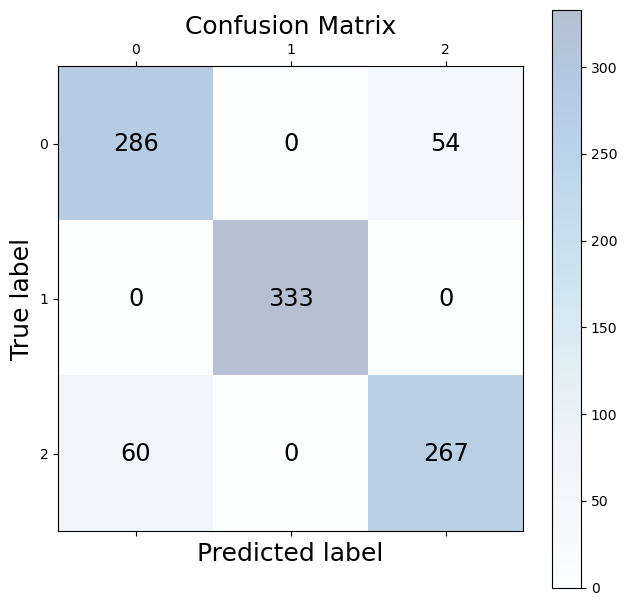

In [349]:
# For Q10
y_pred = fld.predict_using_class_mean(x_test)
print("FLD using class mean, accuracy: ", fld.accuracy_score(y_test, y_pred))

fld.show_confusion_matrix(y_test, y_pred)

In [350]:
# For Q11
y_pred_k1 = fld.predict_using_knn(x_train, y_train, x_test, k=1)
print("FLD using knn (k=1), accuracy: ", fld.accuracy_score(y_test, y_pred_k1))

y_pred_k2 = fld.predict_using_knn(x_train, y_train, x_test, k=2)
print("FLD using knn (k=2), accuracy: ", fld.accuracy_score(y_test, y_pred_k2))

y_pred_k3 = fld.predict_using_knn(x_train, y_train, x_test, k=3)
print("FLD using knn (k=3), accuracy: ", fld.accuracy_score(y_test, y_pred_k3))

y_pred_k4 = fld.predict_using_knn(x_train, y_train, x_test, k=4)
print("FLD using knn (k=4), accuracy: ", fld.accuracy_score(y_test, y_pred_k4))

y_pred_k5 = fld.predict_using_knn(x_train, y_train, x_test, k=5)
print("FLD using knn (k=5), accuracy: ", fld.accuracy_score(y_test, y_pred_k5))

FLD using knn (k=1), accuracy:  0.822
FLD using knn (k=2), accuracy:  0.819
FLD using knn (k=3), accuracy:  0.843
FLD using knn (k=4), accuracy:  0.84
FLD using knn (k=5), accuracy:  0.862


2.034282407737376
-0.4411538399487158
-0.8974314957134626


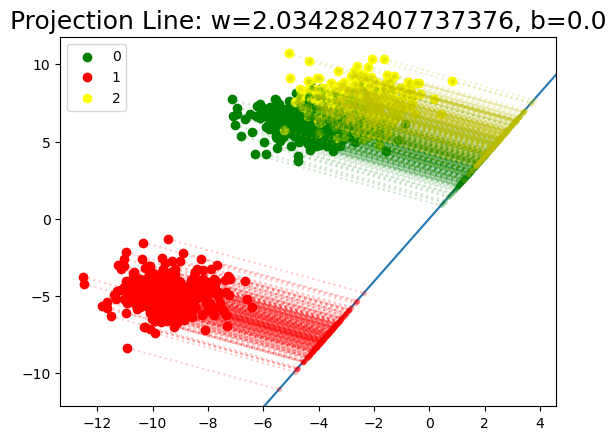

In [351]:
# For Q12, using only training data
fld.plot_projection(x_train, y_train)


# Train your own model on provided dataset.
You can only using 1) **Fisher's Linear Discriminant** or 2) **Logistic Regression** that you have implemented above.

In [393]:
df_train = pd.DataFrame(pd.read_csv("./dataset/PR_HW2_train.csv"))
df_val   = pd.DataFrame(pd.read_csv("./dataset/PR_HW2_val.csv"))
df_test  = pd.DataFrame(pd.read_csv("./dataset/PR_HW2_test.csv"))

In [394]:
df_train.head()

,Feature1,Feature2,Feature3,Feature4,Target
0,0.00668,0.00192,0.682,0.996,2.0
1,0.00680,0.00106,0.503,0.996,1.0
2,0.00742,0.00106,0.482,0.991,1.0
3,0.00685,0.00178,0.650,0.998,2.0
4,0.00680,0.00163,0.623,0.996,2.0


In [395]:
df_val.head()

,Feature1,Feature2,Feature3,Feature4,Target
0,0.00888,0.00223,0.639,0.982,0.0
1,0.00843,0.00199,0.618,0.986,0.0
2,0.00726,0.00199,0.666,0.996,0.0
3,0.00757,0.00188,0.635,0.998,0.0
4,0.00714,0.00195,0.665,0.996,0.0


In [396]:
df_test.head()

,Feature1,Feature2,Feature3,Feature4,Target
0,0.00699,0.000877,0.451,0.994,NaN
1,0.00736,0.001370,0.549,0.998,NaN
2,0.00687,0.001420,0.580,0.992,NaN
3,0.00752,0.002520,0.737,0.996,NaN
4,0.00685,0.000910,0.464,0.992,NaN


In [397]:
df_train["Feature1"] = df_train["Feature1"].apply(lambda x: (x-df_train["Feature1"].min()) / (df_train["Feature1"].max()-df_train["Feature1"].min()))
df_train["Feature2"] = df_train["Feature2"].apply(lambda x: (x-df_train["Feature2"].min()) / (df_train["Feature2"].max()-df_train["Feature2"].min()))
df_train["Feature3"] = df_train["Feature3"].apply(lambda x: (x-df_train["Feature3"].min()) / (df_train["Feature3"].max()-df_train["Feature3"].min()))
df_train["Feature4"] = df_train["Feature4"].apply(lambda x: (x-df_train["Feature4"].min()) / (df_train["Feature4"].max()-df_train["Feature4"].min()))

df_val["Feature1"] = df_val["Feature1"].apply(lambda x: (x-df_val["Feature1"].min()) / (df_val["Feature1"].max()-df_val["Feature1"].min()))
df_val["Feature2"] = df_val["Feature2"].apply(lambda x: (x-df_val["Feature2"].min()) / (df_val["Feature2"].max()-df_val["Feature2"].min()))
df_val["Feature3"] = df_val["Feature3"].apply(lambda x: (x-df_val["Feature3"].min()) / (df_val["Feature3"].max()-df_val["Feature3"].min()))
df_val["Feature4"] = df_val["Feature4"].apply(lambda x: (x-df_val["Feature4"].min()) / (df_val["Feature4"].max()-df_val["Feature4"].min()))

df_test["Feature1"] = df_test["Feature1"].apply(lambda x: (x-df_test["Feature1"].min()) / (df_test["Feature1"].max()-df_test["Feature1"].min()))
df_test["Feature2"] = df_test["Feature2"].apply(lambda x: (x-df_test["Feature2"].min()) / (df_test["Feature2"].max()-df_test["Feature2"].min()))
df_test["Feature3"] = df_test["Feature3"].apply(lambda x: (x-df_test["Feature3"].min()) / (df_test["Feature3"].max()-df_test["Feature3"].min()))
df_test["Feature4"] = df_test["Feature4"].apply(lambda x: (x-df_test["Feature4"].min()) / (df_test["Feature4"].max()-df_test["Feature4"].min()))

In [398]:
x_train = df_train[['Feature1', 'Feature2','Feature3', 'Feature4']].to_numpy()
y_train = df_train[['Target']].to_numpy(dtype=np.int64).ravel()

x_val = df_val[['Feature1', 'Feature2','Feature3', 'Feature4']].to_numpy()
y_val = df_val[['Target']].to_numpy(dtype=np.int64).ravel()

x_test = df_test[['Feature1', 'Feature2','Feature3', 'Feature4']].to_numpy()
y_test = df_test[['Target']].to_numpy(dtype=np.int64).ravel()

print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_val", x_val.shape)
print("y_val", y_val.shape)
print("x_test",  x_test.shape)
print("y_test",  y_test.shape)

x_train (1703, 4)
y_train (1703,)
x_val (730, 4)
y_val (730,)
x_test (5677, 4)
y_test (5677,)


### Logistic Regression

In [411]:
lr = 10
batch_size = 100
epoch = 10000

logistic_reg = MultiClassLogisticRegression()
logistic_reg.fit(x_train, y_train, lr=lr, batch_size=batch_size, epochs=epoch)

In [412]:
print('Validation acc: ', logistic_reg.evaluate(x_train, y_train))

Validation acc:  0.9095713446858485


In [413]:
print('Validation acc: ', logistic_reg.evaluate(x_val, y_val))

Validation acc:  0.8534246575342466


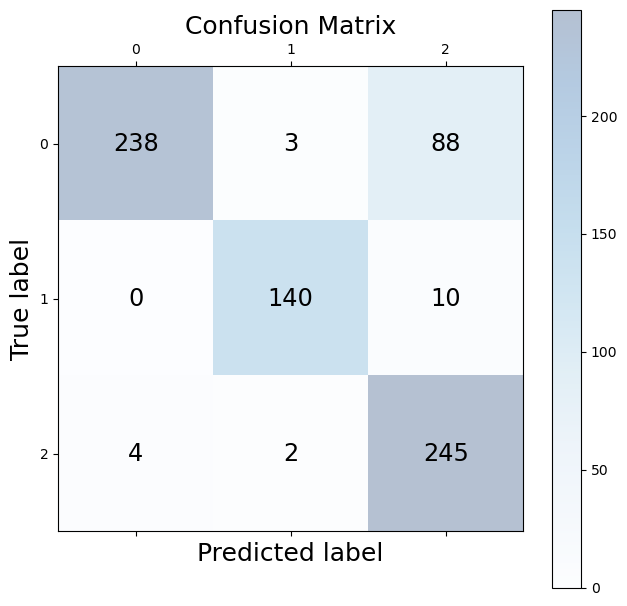

In [414]:
logistic_reg.show_confusion_matrix(x_val, y_val)

In [418]:
x = np.r_[x_train,x_val]
y = np.r_[y_train, y_val]

In [419]:
lr = 10
batch_size = 100
epoch = 10000

logistic_reg = MultiClassLogisticRegression()
logistic_reg.fit(x, y, lr=lr, batch_size=batch_size, epochs=epoch)

In [420]:
test_pred = logistic_reg.predict(x_test)
print("test_pred shape: ", test_pred.shape)

test_pred shape:  (5677,)


# Output the csv file

In [361]:
# For Q13
df_test = pd.DataFrame(pd.read_csv("./dataset/PR_HW2_test.csv"))
df_test["Target"] = test_pred
df_test.to_csv("output.csv")